# PROJET 5 : ÉTUDE DE MARCHÉ

## Préalables :

### A - Importation des librairies

In [1]:
# Importation des librairies :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy import stats as st
from sklearn import preprocessing, decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### B - Importation des fichiers :

In [2]:
# Importations des fichiers :
population_2017 = pd.read_csv("population_2017.csv")
population_2018 = pd.read_csv("population_2018.csv")
proteines_animales = pd.read_csv("proteines_animales.csv")
proteines_globales = pd.read_csv("proteines_globales.csv")
kcal_jour_habitant = pd.read_csv("kcal_jour_habitant.csv")
info_sup = pd.read_csv("Info_supplémentaire_banque_mondiale.csv")

### C - Définition des fonctions :

#### 1 - Cercle des corrélations :

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

#### 2 - Éboulis des valeurs propres :

In [4]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

## I -  Préparation du Dataframe pour étude :

### A - Création d'une variable "Évolution de la population n+1" :

#### 1 - Préparation du dataframe "variable_A" :

In [5]:
# Préparation "population_2017" :
population_2017 = population_2017.rename(columns={"Valeur":"Population_2017"})
population_2017 = population_2017[["Zone","Population_2017"]]
population_2017["Population_2017"] = population_2017["Population_2017"]*1000

# Préparation "population_2018" :
population_2018 = population_2018.rename(columns={"Valeur":"Population_2018"})
population_2018 = population_2018[["Zone","Population_2018"]]
population_2018["Population_2018"] = population_2018["Population_2018"]*1000

# Jointure :
variable_A = pd.merge(population_2018,population_2017, on="Zone")

#### 2 - Création de la colonne "Évolution_population_n+1" :

In [6]:
# Création de la colonne :
variable_A["Évolution_population_n+1"] = (variable_A["Population_2018"] - variable_A["Population_2017"]) / variable_A["Population_2017"] * 100

#### 3 - Suppression des colonnes inutiles :

In [7]:
# Suppression des données de population :
variable_A = variable_A.drop(columns=["Population_2017", "Population_2018"])

#### 4 - Aperçu du dataframe "variable_A" :

In [8]:
# Aperçu :
variable_A.head()

,Zone,Évolution_population_n+1
0,Afghanistan,2.413489
1,Afrique du Sud,1.373443
2,Albanie,-0.034674
3,Algérie,2.027109
4,Allemagne,0.563769


### B - Création de deux variables "disponibilités en protéines par habitant" et "proportion de protéines d'origine animale" :

#### 1 - Groupement des disponibilités en nourriture animale par pays :

In [9]:
# Groupement :
proteines_animales = proteines_animales[["Zone","Valeur"]].groupby(by="Zone", as_index=False).sum()

# Changement du nom de la colonne :
proteines_animales = proteines_animales.rename(columns={"Valeur":"Proteines_animales"})

#### 2 - Groupement des disponibilités en nourriture totale par pays :

In [10]:
# Groupement :
proteines_globales = proteines_globales[["Zone","Valeur"]].groupby(by="Zone", as_index=False).sum()

# Changement du nom de la colonne :
proteines_globales = proteines_globales.rename(columns={"Valeur":"Proteines_globales"})

#### 3 - Préparation du dataframe "variable_B" :

In [11]:
# Jointure :
variable_B = pd.merge(proteines_globales, proteines_animales, on = "Zone")

# Remplacement des "0" en prévision d'une division :
variable_B = variable_B.replace(0, np.NaN)

#### 4 - Création de la colonne "pourcentage_proteines_animales" :

In [12]:
# Calcul et création de la colonne "Pourcentage_proteines_animales" :
variable_B["Pourcentage_proteines_animales"] = variable_B["Proteines_animales"] / variable_B["Proteines_globales"]*100

#### 5 - Création d'une colonne "disponibilité en kg de protéines par habitant" :

In [13]:
# Conversion :
variable_B["Kilos_protéines_par_habitant"] = variable_B["Proteines_animales"] * 365 / 1000

#### 6 - Suppression des colonnes inutiles :

In [14]:
# Suppression :
variable_B = variable_B.drop(columns=["Proteines_globales","Proteines_animales"])

#### 5 - Aperçu du dataframe "variable_B" :

In [15]:
# Aperçu :
variable_B.head()

,Zone,Pourcentage_proteines_animales,Kilos_protéines_par_habitant
0,Afghanistan,19.434438,3.93835
1,Afrique du Sud,42.704753,13.15095
2,Albanie,53.352341,22.53875
3,Algérie,26.930197,9.02645
4,Allemagne,60.749526,23.37095


### C - Création d'une variable disponibilité alimentaire en calories par habitant :

#### 1 - Groupement des disponibilités en kcal/habitant par pays :

In [16]:
# Groupement :
variable_C = kcal_jour_habitant[["Zone","Valeur"]].groupby(by="Zone", as_index=False).sum()

#### 2 - Conversion des unités en kcal_par_habitant :

In [17]:
# Conversion :
variable_C["Valeur"] = variable_C["Valeur"] * 365

# Changement du nom de la colonne :
variable_C = variable_C.rename(columns={"Valeur":"Kcal_par_habitant"})

#### 3 - Aperçu du dataframe "variable_C" :

In [18]:
# Aperçu :
variable_C.head()

,Zone,Kcal_par_habitant
0,Afghanistan,743870
1,Afrique du Sud,1056675
2,Albanie,1226765
3,Algérie,1212165
4,Allemagne,1297210


### D - Création du dataframe d'étude "Projet5" :

#### 1 - Jointures des trois variables précédentes :

In [19]:
# Jointures :
projet5 = pd.merge(variable_A, variable_B, on="Zone")
projet5 = pd.merge(projet5, variable_C, on="Zone")

#### 2 - Aperçu du dataframe d'étude "projet5" :

In [20]:
# Aperçu :
projet5.head()

,Zone,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant
0,Afghanistan,2.413489,19.434438,3.93835,743870
1,Afrique du Sud,1.373443,42.704753,13.15095,1056675
2,Albanie,-0.034674,53.352341,22.53875,1226765
3,Algérie,2.027109,26.930197,9.02645,1212165
4,Allemagne,0.563769,60.749526,23.37095,1297210


#### 3 - Changement d'index :

In [21]:
# Attribution de l'index à la colonne "Zone" :
dataAED = projet5.set_index("Zone")
dataAED = dataAED.fillna(dataAED.mean())
dataAED.head()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant
Zone,,,,
Afghanistan,2.413489,19.434438,3.93835,743870
Afrique du Sud,1.373443,42.704753,13.15095,1056675
Albanie,-0.034674,53.352341,22.53875,1226765
Algérie,2.027109,26.930197,9.02645,1212165
Allemagne,0.563769,60.749526,23.37095,1297210


#### 4 - Aperçu des corrélations de variables :

In [22]:
# Création d'une matrice de corrélation :
dataAED.corr()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant
Évolution_population_n+1,1.000000,-0.600939,-0.576616,-0.501141
Pourcentage_proteines_animales,-0.600939,1.000000,0.933607,0.617515
Kilos_protéines_par_habitant,-0.576616,0.933607,1.000000,0.769051
Kcal_par_habitant,-0.501141,0.617515,0.769051,1.000000


## II - Dendrogramme :

### A - Préparation des données :

#### 1 - Préparation pour clustering :

In [23]:
# Définitions :
X = dataAED.values
pays = dataAED.index

#### 2 - Centrage et réduction :

In [24]:
# Centrage et réduction :
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [25]:
# Vérification des moyennes :
np.mean(X_scaled, axis=0)

array([ 0.00000000e+00, -1.18768044e-16, -2.89174369e-16,  4.13106242e-17])

In [26]:
# Vérification des écarts-type :
np.std(X_scaled,axis=0,ddof=0)

array([1., 1., 1., 1.])

#### 4 - Clustering hiérarchique :

In [27]:
# Clustering hiérarchique :
Z = linkage(X_scaled,"ward")

### B - Construction du Dendrogramme :

#### 1 - Affichage :

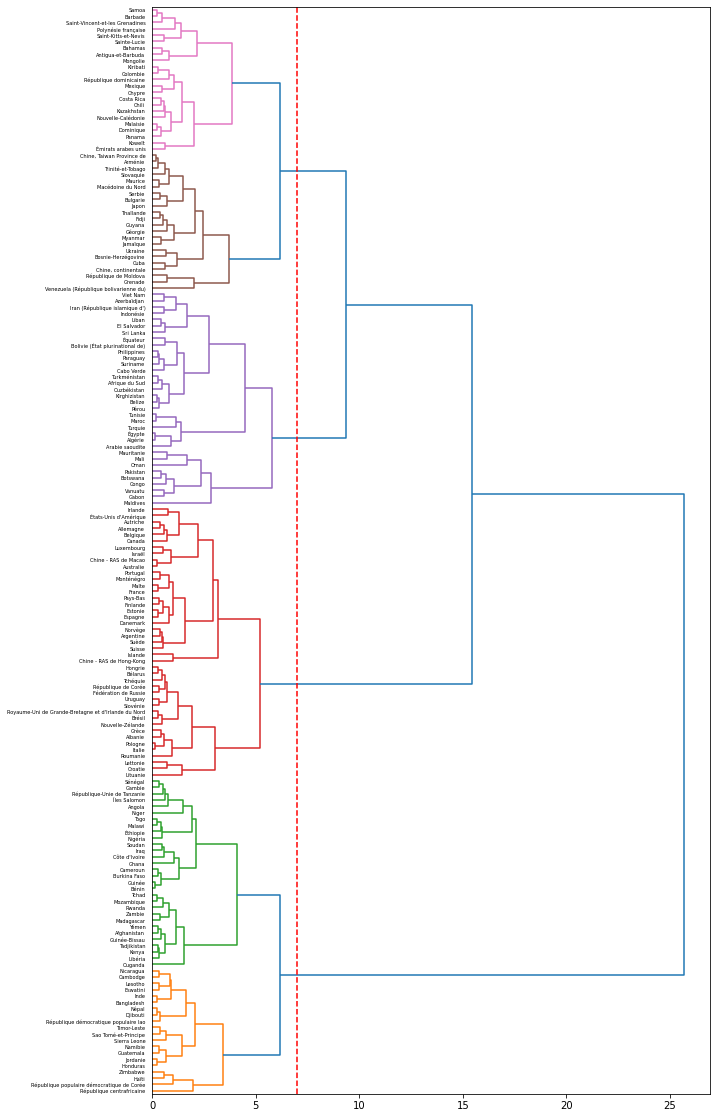

In [28]:
plt.figure(figsize=(10,20))
dendrogram(Z, labels=pays,orientation="right",color_threshold=6)
plt.axvline(c="red",linestyle='--', x=7)
plt.show()

#### 2 - Conclusion :

## III - Analyse en composantes principales :

### A - Éboulis des valeurs propres :

In [29]:
# Calcul des composantes principales :
n_comp = 4
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

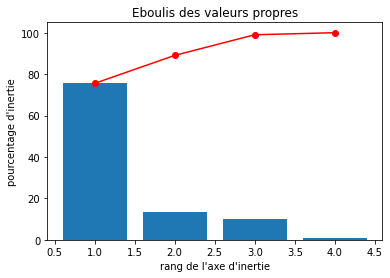

In [30]:
# Visualisation :
display_scree_plot(pca)

### B - Cercle des corrélations :

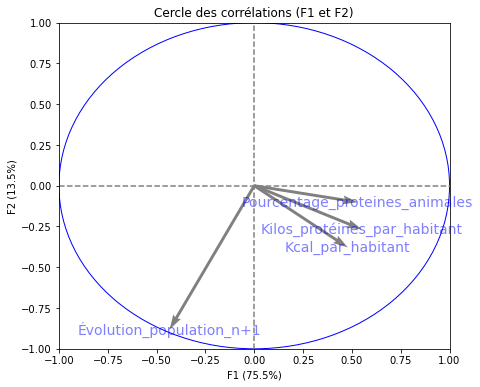

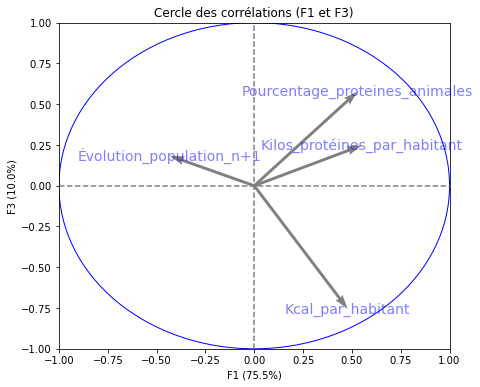

In [31]:
# Cercle des corrélations :
pcs = pca.components_
labelsVariables = dataAED.columns
display_circles(pcs, 3, pca,[(0,1),(0,2)],labels = np.array(labelsVariables))

### C - Interprétation :

## IV - Clustering (6 groupes) :

### A - Clustering à partir du dendrogramme (méthode Ward) :

#### 1 - Découpage du dendrogramme en 6 clusters :

In [32]:
# Clustering :
clustersDen = fcluster(Z, 6, criterion="maxclust")

#### 2 - Création des tableaux par clusters (Den) :

In [33]:
# Attribution des numéros de cluster :
dataClusterDen = pd.DataFrame({"Zone": pays, "cluster":clustersDen})

# Jointure avec le dataframe principal :
dataClusterDen = pd.merge(projet5, dataClusterDen, on="Zone")

# Groupement par cluster
dataClusterDen1 = dataClusterDen.loc[dataClusterDen["cluster"]==1]
dataClusterDen2 = dataClusterDen.loc[dataClusterDen["cluster"]==2]
dataClusterDen3 = dataClusterDen.loc[dataClusterDen["cluster"]==3]
dataClusterDen4 = dataClusterDen.loc[dataClusterDen["cluster"]==4]
dataClusterDen5 = dataClusterDen.loc[dataClusterDen["cluster"]==5]
dataClusterDen6 = dataClusterDen.loc[dataClusterDen["cluster"]==6]

# Groupement par moyenne :
dataClusterMoy = dataClusterDen.groupby(by="cluster").mean()

# Export des numéros de clusters par pays :
# clusterPays = dataClusterDen[["Zone","cluster"]]
# clusterPays.to_csv("clusterPays.csv", index=False, encoding="ISO-8859-1")

#### 3 - Projections des clusters (Den) :

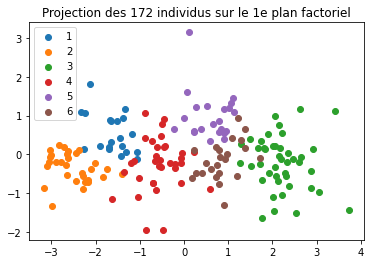

In [34]:
# Calculs de la projection :
pcaDen = decomposition.PCA().fit(X_scaled)
Z_projected = pca.transform(X_scaled)

# Visualisation de la projection F1/F2 Den :
label = clustersDen
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 1] , label = i)
plt.legend(loc="upper left")
plt.title("Projection des {} individus sur le 1e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

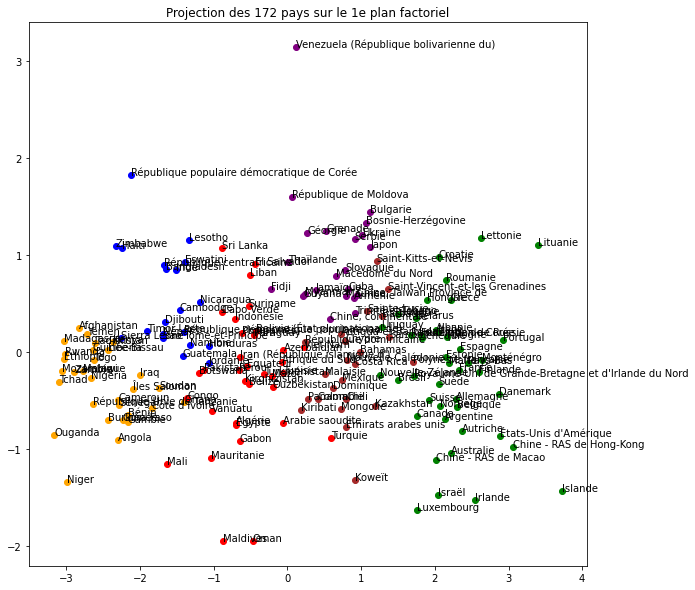

In [35]:
# Visualisation de la projection F1/F2 Den : (avec les noms de pays):
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange','green','red','purple','brown'],[1,2,3,4,5,6]):
    plt.scatter(Z_projected[clustersDen==k,0] , Z_projected[clustersDen==k,1],c=couleur)
for i,label in enumerate(dataAED.index):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,1]))
plt.title("Projection des {} pays sur le 1e plan factoriel".format(Z_projected.shape[0]))
plt.show()

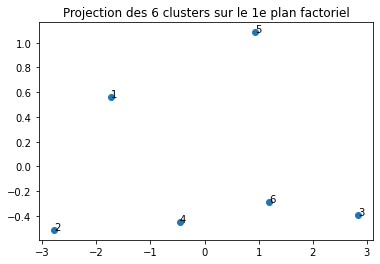

In [36]:
# Calcul des centroïdes de groupes :
std_scale = preprocessing.StandardScaler().fit(dataClusterMoy)
centroidsDen = std_scale.transform(dataClusterMoy)
projectCentroidsDen = decomposition.PCA().fit(centroidsDen)
centroidsDen_projected = pca.transform(centroidsDen)

# Affichage des positions des centroïdes de groupe F1/F2 Den :
plt.figure(figsize=(6,4))
plt.scatter(centroidsDen_projected[:,0], centroidsDen_projected[:,1])
for i,label in enumerate(dataClusterMoy.index):
    plt.annotate(label,(centroidsDen_projected[i,0],centroidsDen_projected[i,1]))
plt.title("Projection des {} clusters sur le 1e plan factoriel".format(centroidsDen_projected.shape[0]))
plt.show()

# Export des coordonnées de centroïdes de groupe :

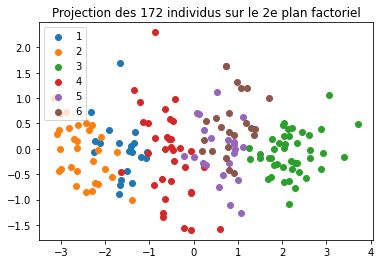

In [37]:
# Visualisation de la projection F1/F3 Den :
label = clustersDen
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 2] , label = i)
plt.legend(loc="upper left")
plt.title("Projection des {} individus sur le 2e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

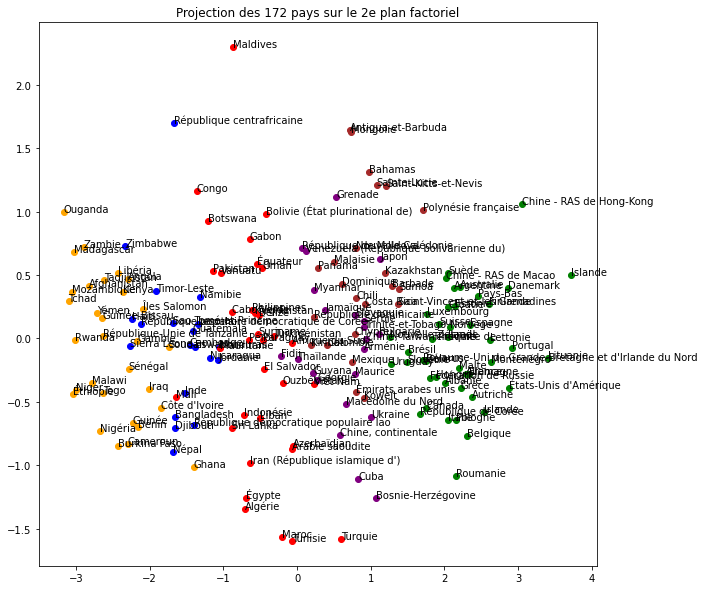

In [38]:
# Visualisation de la projection F1/F3 Den : (avec les noms de pays):
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange','green','red','purple','brown'],[1,2,3,4,5,6]):
    plt.scatter(Z_projected[clustersDen==k,0] , Z_projected[clustersDen==k,2],c=couleur)
for i,label in enumerate(dataAED.index):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,2]))
plt.title("Projection des {} pays sur le 2e plan factoriel".format(Z_projected.shape[0]))
plt.show()

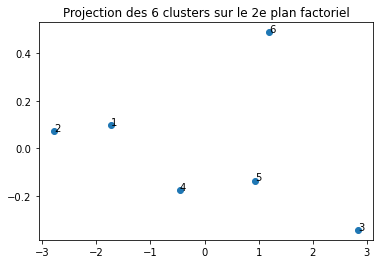

In [39]:
# Affichage des positions des centroïdes de groupe F1/F3 Den :
plt.figure(figsize=(6,4))
plt.scatter(centroidsDen_projected[:,0], centroidsDen_projected[:,2])
for i,label in enumerate(dataClusterMoy.index):
    plt.annotate(label,(centroidsDen_projected[i,0],centroidsDen_projected[i,2]))
plt.title("Projection des {} clusters sur le 2e plan factoriel".format(centroidsDen_projected.shape[0]))
plt.show()

In [40]:
# Coordonnées des centroïdes du clustering Ward :
coordonneesCentroides = pd.DataFrame(centroidsDen, columns=dataClusterMoy.columns, index=dataClusterMoy.index)
coordonneesCentroides

# Export des coordonnées des centroïdes :
# coordonneesCentroides.to_csv("coordonneesCentroides.csv", encoding="ISO-8859-1")

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant
cluster,,,,
1,0.264663,-0.969442,-1.005118,-1.131429
2,1.664963,-1.468859,-1.272613,-1.228578
3,-0.952596,1.288300,1.654336,1.747595
4,0.565524,-0.226905,-0.260511,0.113728
5,-1.379906,0.339527,0.146270,0.151619
6,-0.162648,1.037378,0.737635,0.347066


### B - Caractérisation des groupes du dendrogramme :

#### 1 - Analyse des tableaux des clusters Ward :

In [41]:
# Description 1er Cluster :
dataClusterDen1.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,20.000000,20.000000,20.000000,2.000000e+01,20.0
mean,1.480656,27.673865,6.142037,8.845045e+05,1.0
std,0.447575,6.466393,1.532695,1.028838e+05,0.0
min,0.471884,19.101426,3.723000,6.511600e+05,1.0
25%,1.216345,22.181885,4.984075,8.439712e+05,1.0
50%,1.545366,28.484781,6.296250,9.044700e+05,1.0
75%,1.840023,31.091084,7.185937,9.504600e+05,1.0
max,2.163462,44.347241,8.475300,1.010685e+06,1.0


In [42]:
# Description 2e Cluster :
dataClusterDen2.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,30.000000,30.000000,30.000000,3.000000e+01,30.0
mean,2.756826,20.536400,4.384380,8.723865e+05,2.0
std,0.390035,5.296165,1.129910,1.041552e+05,0.0
min,2.218330,9.874868,2.390750,7.059100e+05,2.0
25%,2.488412,15.949682,3.505825,7.865750e+05,2.0
50%,2.674905,20.895783,4.261375,8.714375e+05,2.0
75%,2.942919,24.617990,5.156537,9.396012e+05,2.0
max,3.893158,30.744581,7.354750,1.105585e+06,2.0


In [43]:
# Description 3e Cluster :
dataClusterDen3.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,43.000000,43.000000,43.000000,4.300000e+01,43.0
mean,0.371302,59.940562,23.616773,1.243623e+06,3.0
std,0.707529,5.250069,4.209071,6.339263e+04,0.0
min,-1.546573,49.047968,16.870300,1.120915e+06,3.0
25%,0.015873,55.655882,20.522125,1.203952e+06,3.0
50%,0.303260,60.738101,23.524250,1.228590e+06,3.0
75%,0.816402,63.145802,25.727025,1.277682e+06,3.0
max,2.027027,73.087995,38.317700,1.418025e+06,3.0


In [44]:
# Description 4e Cluster :
dataClusterDen4.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,34.000000,34.000000,34.000000,3.400000e+01,34.0
mean,1.754847,38.285880,11.034701,1.039821e+06,4.0
std,0.807478,7.669774,2.396702,1.258518e+05,0.0
min,0.478039,26.881206,6.475100,8.157750e+05,4.0
25%,1.268338,32.984044,9.613188,9.635088e+05,4.0
50%,1.614831,38.922726,10.347750,1.023460e+06,4.0
75%,2.072634,42.659920,12.801462,1.102300e+06,4.0
max,4.032258,60.388732,17.917850,1.353420e+06,4.0


In [45]:
# Description 5e Cluster :
dataClusterDen5.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,22.000000,22.000000,22.000000,2.200000e+01,22.0
mean,-0.018129,46.381093,13.707575,1.044547e+06,5.0
std,0.567787,5.430882,2.275019,1.064568e+05,0.0
min,-1.751582,37.421575,8.968050,7.738000e+05,5.0
25%,-0.226316,41.488550,12.670975,1.013788e+06,5.0
50%,0.069904,45.996476,13.809775,1.045178e+06,5.0
75%,0.403890,50.261700,15.262475,1.106862e+06,5.0
max,0.684151,56.660123,17.739000,1.219830e+06,5.0


In [46]:
# Description 6e Cluster :
dataClusterDen6.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,23.000000,23.000000,23.000000,2.300000e+01,23.0
mean,1.091224,56.354492,17.593317,1.068926e+06,6.0
std,0.550007,6.119950,2.506163,8.833088e+04,0.0
min,0.000000,45.764557,12.220200,8.913300e+05,6.0
25%,0.743675,50.827892,16.187750,1.034958e+06,6.0
50%,1.084372,55.775297,18.104000,1.078575e+06,6.0
75%,1.463159,61.081346,18.945325,1.111972e+06,6.0
max,1.997041,66.046946,23.210350,1.266915e+06,6.0


#### 2 - Visualisation des caractéristiques des clusters du dendrogramme :

Text(0.5, 1.0, 'Évolution de la population par cluster')

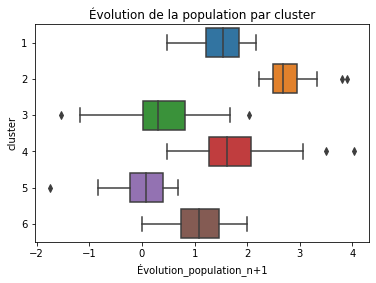

In [47]:
# Boxplot "Évolution de la population" :
sns.boxplot(x=dataClusterDen["Évolution_population_n+1"], y=dataClusterDen["cluster"], orient="h")
plt.title("Évolution de la population par cluster")

Text(0.5, 1.0, "Pourcentage de protéines animales dans l'alimentation par cluster")

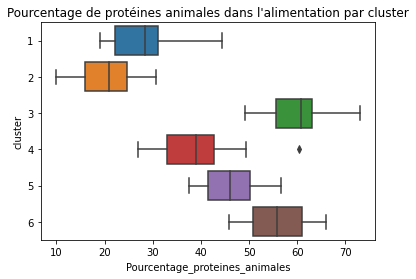

In [48]:
# Boxplot "Pourcentage_proteines_animales" :
sns.boxplot(x=dataClusterDen["Pourcentage_proteines_animales"], y=dataClusterDen["cluster"], orient="h")
plt.title("Pourcentage de protéines animales dans l'alimentation par cluster")

Text(0.5, 1.0, 'Protéines/habitants par cluster')

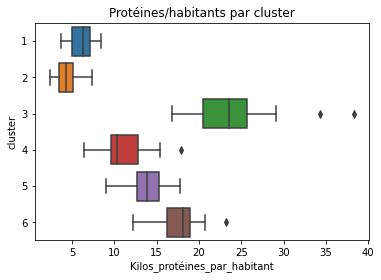

In [49]:
# Boxplot "Kilos_protéines_par_habitant" :
sns.boxplot(x=dataClusterDen["Kilos_protéines_par_habitant"], y=dataClusterDen["cluster"], orient="h")
plt.title("Protéines/habitants par cluster")

Text(0.5, 1.0, 'Kcal/habitants par cluster')

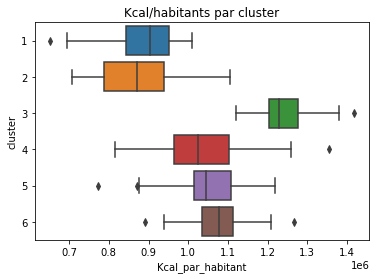

In [50]:
# Boxplot "Kcal_par_habitant"
sns.boxplot(x=dataClusterDen["Kcal_par_habitant"], y=dataClusterDen["cluster"], orient="h")
plt.title("Kcal/habitants par cluster")

### C - Clustering par K-Means :

#### 1 - K-Means et projections :

In [51]:
# K-Means :
n_clust = 6
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)
clustersKM = km.labels_

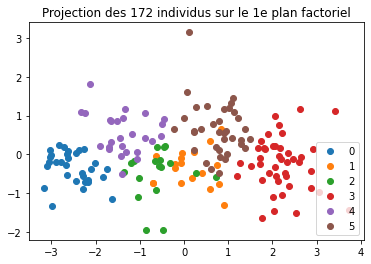

In [52]:
# Affichage projection F1/F2 KM :
label = clustersKM
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 1] , label = i)
plt.legend(loc="lower right")
plt.title("Projection des {} individus sur le 1e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

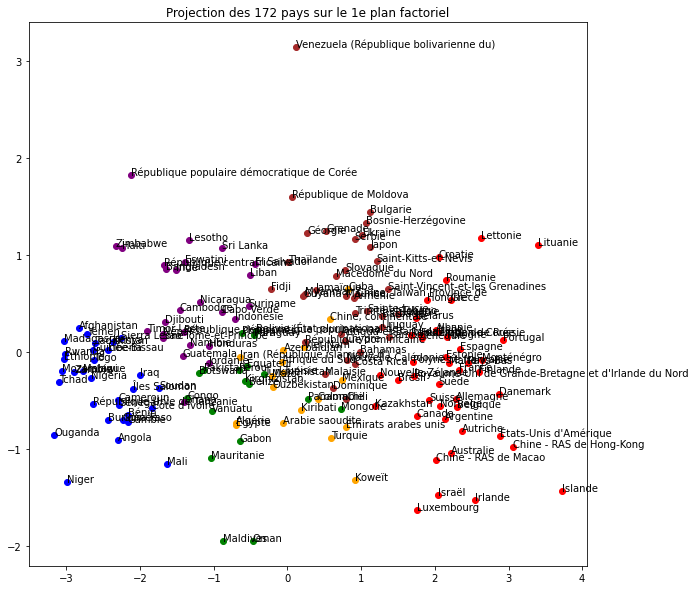

In [53]:
# Projection F1/F2 KM (avec les noms de pays):
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange','green','red','purple','brown'],[0,1,2,3,4,5]):
    plt.scatter(Z_projected[clustersKM==k,0] , Z_projected[clustersKM==k,1],c=couleur)
for i,label in enumerate(dataAED.index):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,1]))
plt.title("Projection des {} pays sur le 1e plan factoriel".format(Z_projected.shape[0]))
plt.show()

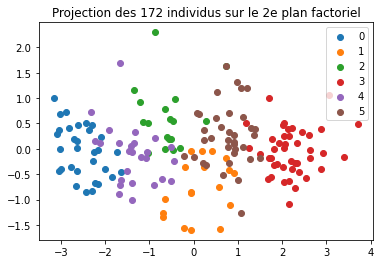

In [54]:
# Affichage projection F1/F3 KM :
label = clustersKM
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 2] , label = i)
plt.legend(loc="upper right")
plt.title("Projection des {} individus sur le 2e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

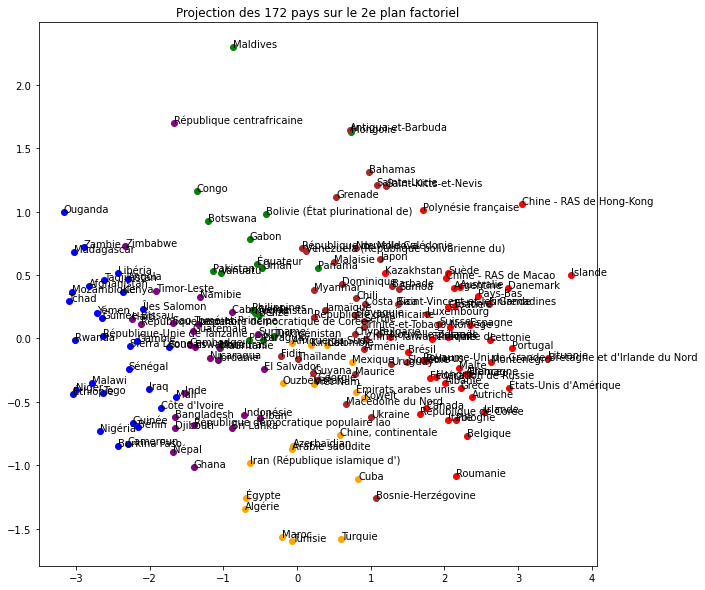

In [55]:
# Projection F1/F3 KM (avec les noms de pays):
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange','green','red','purple','brown'],[0,1,2,3,4,5]):
    plt.scatter(Z_projected[clustersKM==k,0] , Z_projected[clustersKM==k,2],c=couleur)
for i,label in enumerate(dataAED.index):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,2]))
plt.title("Projection des {} pays sur le 2e plan factoriel".format(Z_projected.shape[0]))
plt.show()

#### 2 - Centroïdes :

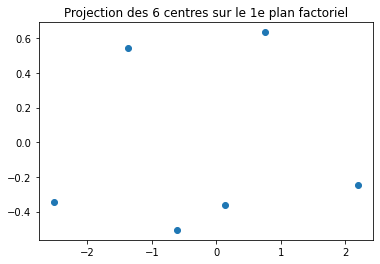

In [56]:
# Affichage des positions des centroïdes de groupes F1/F2 KM :
plt.figure()
centroidsKM = km.cluster_centers_
centroids_projectedKM = pca.transform(centroidsKM)
plt.scatter(centroids_projectedKM[:,0],centroids_projectedKM[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroidsKM)))
plt.show()

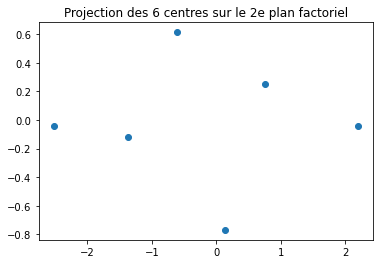

In [57]:
# Affichage des positions des centroïdes de groupes F1/F3 KM :
plt.scatter(centroids_projectedKM[:,0],centroids_projectedKM[:,2])
plt.title("Projection des {} centres sur le 2e plan factoriel".format(len(centroidsKM)))
plt.show()

### D - Caractérisation des groupes obtenus par K-Means :

#### 1 - Création des tableaux des clusters K-Means :

In [58]:
# Attribution des numéros de cluster :
dataClusterKM = pd.DataFrame({"Zone": pays, "cluster":clustersKM})

# Jointure avec le dataframe principal :
dataClusterKM = pd.merge(projet5, dataClusterKM, on="Zone")

# Groupement par cluster
dataClusterKM0 = dataClusterKM.loc[dataClusterKM["cluster"]==0]
dataClusterKM1 = dataClusterKM.loc[dataClusterKM["cluster"]==1]
dataClusterKM2 = dataClusterKM.loc[dataClusterKM["cluster"]==2]
dataClusterKM3 = dataClusterKM.loc[dataClusterKM["cluster"]==3]
dataClusterKM4 = dataClusterKM.loc[dataClusterKM["cluster"]==4]
dataClusterKM5 = dataClusterKM.loc[dataClusterKM["cluster"]==5]

#### 1 - Analyse des tableaux des clusters K-Means :

In [59]:
# Description 1er cluster :
dataClusterKM0.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,31.000000,31.000000,31.000000,3.100000e+01,31.0
mean,2.764755,20.660764,4.461477,8.702895e+05,0.0
std,0.389968,5.283384,1.290336,9.852497e+04,0.0
min,2.163462,9.874868,2.390750,7.059100e+05,0.0
25%,2.488521,16.236546,3.595250,7.876700e+05,0.0
50%,2.676853,21.190854,4.259550,8.697950e+05,0.0
75%,2.955631,24.465974,5.104525,9.389625e+05,0.0
max,3.893158,30.744581,8.201550,1.048645e+06,0.0


In [60]:
# Description 2e cluster :
dataClusterKM1.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,18.000000,18.000000,18.000000,1.800000e+01,18.0
mean,1.370393,38.459276,13.021172,1.182336e+06,1.0
std,0.533215,8.317543,2.857167,7.294607e+04,0.0
min,-0.008819,26.930197,9.026450,1.056675e+06,1.0
25%,1.138554,30.256644,10.803088,1.128215e+06,1.0
50%,1.452346,38.837349,13.096200,1.182418e+06,1.0
75%,1.719419,44.999606,14.458562,1.217914e+06,1.0
max,2.054063,51.165661,18.604050,1.353420e+06,1.0


In [61]:
# Description 3e cluster :
dataClusterKM2.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,18.000000,18.000000,18.000000,1.800000e+01,18.0
mean,2.153328,45.592161,12.509158,9.604975e+05,2.0
std,0.735275,7.604550,3.133715,7.649856e+04,0.0
min,1.296054,36.117876,9.606800,8.157750e+05,2.0
25%,1.711615,40.404712,10.232775,9.149638e+05,2.0
50%,1.851691,42.776226,11.232875,9.656075e+05,2.0
75%,2.563561,48.114347,13.498613,1.013058e+06,2.0
max,4.032258,65.112816,20.750250,1.072370e+06,2.0


In [62]:
# Description 4e cluster :
dataClusterKM3.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,43.000000,43.000000,43.000000,4.300000e+01,43.0
mean,0.408664,60.388171,23.793671,1.240066e+06,3.0
std,0.722561,5.112904,4.043028,6.988956e+04,0.0
min,-1.546573,49.047968,18.698950,1.061420e+06,3.0
25%,0.015873,56.479455,20.748425,1.203952e+06,3.0
50%,0.348918,60.749526,23.524250,1.228590e+06,3.0
75%,0.849892,63.760212,25.727025,1.277682e+06,3.0
max,2.027027,73.087995,38.317700,1.418025e+06,3.0


In [63]:
# Description 5e cluster :
dataClusterKM4.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,26.000000,26.000000,26.000000,2.600000e+01,26.0
mean,1.336404,29.243993,6.739725,9.198983e+05,4.0
std,0.506238,6.510975,1.702817,1.102744e+05,0.0
min,0.471884,19.101426,3.723000,6.511600e+05,4.0
25%,1.045553,23.996309,5.508762,8.865850e+05,4.0
50%,1.361188,29.129869,6.789000,9.333050e+05,4.0
75%,1.683598,33.286193,7.993500,9.930738e+05,4.0
max,2.218330,44.347241,9.822150,1.105585e+06,4.0


In [64]:
# Description 6e cluster :
dataClusterKM5.describe()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,cluster
count,36.000000,36.000000,36.000000,3.600000e+01,36.0
mean,0.310959,51.522945,15.418715,1.040737e+06,5.0
std,0.672198,7.137174,2.857074,9.071050e+04,0.0
min,-1.751582,37.421575,8.968050,7.738000e+05,5.0
25%,0.000000,46.168147,13.493137,1.006670e+06,5.0
50%,0.332063,51.172323,15.833700,1.051565e+06,5.0
75%,0.703791,55.825707,17.847588,1.101570e+06,5.0
max,1.408451,64.939893,19.538450,1.205230e+06,5.0


#### 2 - Visualisation des caractéristiques des clusters K-Means :

Text(0.5, 1.0, 'Évolution de la population par cluster')

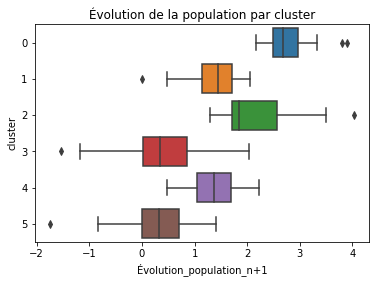

In [65]:
# Boxplot "Évolution de la population" :
sns.boxplot(x=dataClusterKM["Évolution_population_n+1"], y=dataClusterKM["cluster"], orient="h")
plt.title("Évolution de la population par cluster")

Text(0.5, 1.0, 'Part des protéines animales par cluster')

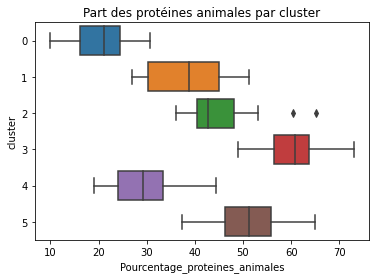

In [66]:
# Boxplot "Pourcentage_proteines_animales" :
sns.boxplot(x=dataClusterKM["Pourcentage_proteines_animales"], y=dataClusterKM["cluster"], orient="h")
plt.title("Part des protéines animales par cluster")

Text(0.5, 1.0, 'Protéines/habitants par cluster')

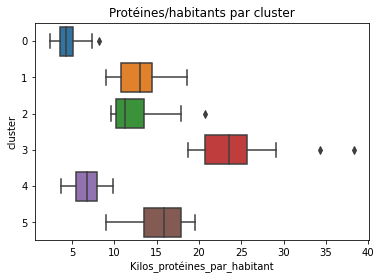

In [67]:
# Boxplot "Kilos_protéines_par_habitant" :
sns.boxplot(x=dataClusterKM["Kilos_protéines_par_habitant"], y=dataClusterKM["cluster"], orient="h")
plt.title("Protéines/habitants par cluster")

Text(0.5, 1.0, 'Part des Kcal/habitant par cluster')

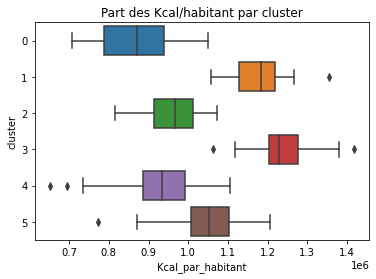

In [68]:
# Boxplot "Kcal_par_habitant"
sns.boxplot(x=dataClusterKM["Kcal_par_habitant"], y=dataClusterKM["cluster"], orient="h")
plt.title("Part des Kcal/habitant par cluster")

#### 3 - Interprétation :

## V - Tests statistiques :

### A - Test d'adéquation :

#### 1 - Sur "Évolution_population_n+1"

<AxesSubplot:xlabel='Évolution_population_n+1', ylabel='Density'>

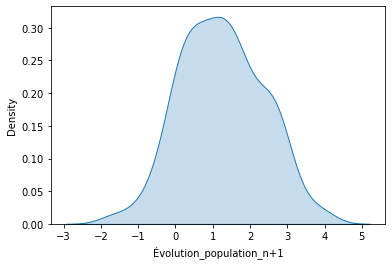

In [69]:
# Visualisation sur "Évolution_population_n+1" :
sns.kdeplot(dataClusterDen["Évolution_population_n+1"], shade=True)

In [70]:
# Test de Shapiro-Wilk sur "Évolution_population_n+1" :
st.shapiro(dataClusterDen["Évolution_population_n+1"])

ShapiroResult(statistic=0.9918509721755981, pvalue=0.4414202570915222)

#### 2 - Sur "Pourcentage_proteines_animales"

<AxesSubplot:xlabel='Pourcentage_proteines_animales', ylabel='Density'>

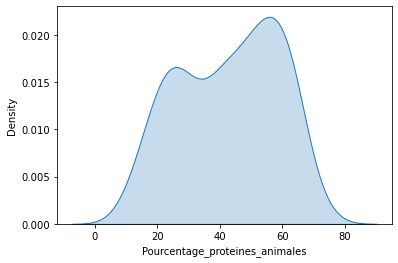

In [71]:
# Visualisation sur "Pourcentage_proteines_animales" :
sns.kdeplot(dataClusterDen["Pourcentage_proteines_animales"], shade=True)

In [72]:
# Test de Shapiro-Wilk sur "Pourcentage_proteines_animales" :
st.shapiro(dataClusterDen["Pourcentage_proteines_animales"])

ShapiroResult(statistic=0.9546793103218079, pvalue=2.401052915956825e-05)

#### 3 - Sur "Kilos_protéines_par_habitant" :

<AxesSubplot:xlabel='Kilos_protéines_par_habitant', ylabel='Density'>

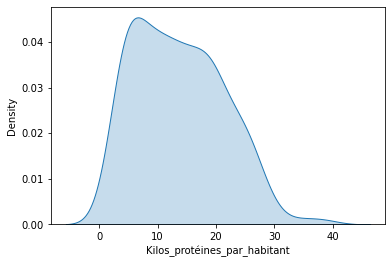

In [73]:
# Visualisation sur "Kilos_protéines_par_habitant" :
sns.kdeplot(dataClusterDen["Kilos_protéines_par_habitant"], shade=True)

In [74]:
# Test de Shapiro-Wilk sur "Kilos_protéines_par_habitant" :
st.shapiro(dataClusterDen["Kilos_protéines_par_habitant"])

ShapiroResult(statistic=0.9555334448814392, pvalue=2.8900411052745767e-05)

#### 4 - Sur "Kcal_par_habitant" :

<AxesSubplot:xlabel='Kcal_par_habitant', ylabel='Density'>

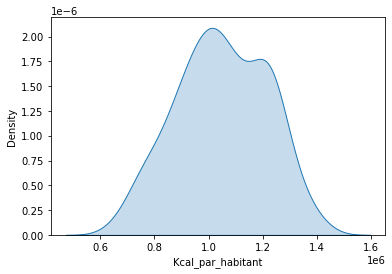

In [75]:
# Visualisation "Kcal_par_habitant":
sns.kdeplot(dataClusterDen["Kcal_par_habitant"], shade=True)

In [76]:
# Test de Shapiro-Wilk sur "Kcal_par_habitant" :
st.shapiro(dataClusterDen["Kcal_par_habitant"])

ShapiroResult(statistic=0.985912561416626, pvalue=0.08118238300085068)

#### 5 - Conclusion :

### B - Test de comparaison :

#### 1 - Visualisation des distribution de "Évolution_population_n+1" pour les 6 clusters :

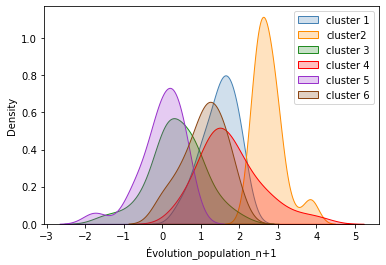

In [77]:
# Visualisation :
plt.figure()
sns.kdeplot(dataClusterDen1["Évolution_population_n+1"], shade=True,color="steelblue", label="cluster 1")
sns.kdeplot(dataClusterDen2["Évolution_population_n+1"], shade=True, color="darkorange", label="cluster2")
sns.kdeplot(dataClusterDen3["Évolution_population_n+1"], shade=True, color="forestgreen", label="cluster 3")
sns.kdeplot(dataClusterDen4["Évolution_population_n+1"], shade=True, color="red", label="cluster 4")
sns.kdeplot(dataClusterDen5["Évolution_population_n+1"], shade=True, color="darkorchid", label="cluster 5")
sns.kdeplot(dataClusterDen6["Évolution_population_n+1"], shade=True, color="saddlebrown", label="cluster 6")
plt.legend()

#### 2 - Comparaison des 1er et 2e  cluster sur la variable "Évolution_population_n+1" :

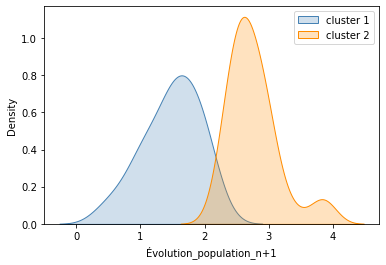

In [78]:
# Visualisation des clusters 1 et 2 :
plt.figure()
sns.kdeplot(dataClusterDen1["Évolution_population_n+1"], shade=True, color="steelblue", label="cluster 1")
sns.kdeplot(dataClusterDen2["Évolution_population_n+1"], shade=True, color="darkorange", label="cluster 2")
plt.legend()

In [79]:
# Test des variances (Bartlett) :
st.bartlett(dataClusterDen1["Évolution_population_n+1"], dataClusterDen3["Évolution_population_n+1"])

BartlettResult(statistic=4.691646286860213, pvalue=0.030309594341863692)

In [80]:
# Test des moyennes (Student) :
st.ttest_ind(dataClusterDen1["Évolution_population_n+1"],dataClusterDen2["Évolution_population_n+1"])

Ttest_indResult(statistic=-10.684171846666418, pvalue=2.7757487209658514e-14)

#### 3 - Comparaison des 5er et 6e  cluster (les deux clusters en ballotage) sur la variable "Évolution_population_n+1" :

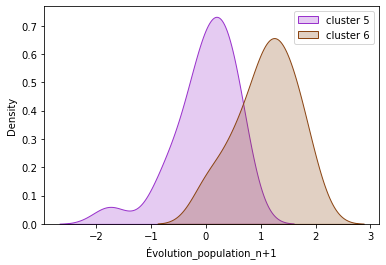

In [81]:
# Visualisation des clusters 5 et 6 :
plt.figure()
sns.kdeplot(dataClusterDen5["Évolution_population_n+1"], shade=True, color="darkorchid", label="cluster 5")
sns.kdeplot(dataClusterDen6["Évolution_population_n+1"], shade=True, color="saddlebrown", label="cluster 6")
plt.legend()

In [82]:
# Test des variances (Bartlett) :
st.bartlett(dataClusterDen5["Évolution_population_n+1"], dataClusterDen6["Évolution_population_n+1"])

BartlettResult(statistic=0.021261166863406233, pvalue=0.8840697280285136)

In [83]:
# Test des moyennes (Student) :
st.ttest_ind(dataClusterDen5["Évolution_population_n+1"],dataClusterDen6["Évolution_population_n+1"])

Ttest_indResult(statistic=-6.657526726152063, pvalue=4.039695028068295e-08)

## VI - Choix des pays d'implantation :

### A - Choix du cluster et méthodologie de ciblage :

#### 1 - Choix du cluster :

## Le cluster 6 (de la méthode Ward) est intéressant :
- Il réunit des pays en voie d'enrichissement qui sont néanmoins encore loin des caractéristiques nutritionnelles du cluster 3 qui réunit les pays à l'alimentation la plus riche (et qui correspond globalement aux pays les plus riches).

- Les pays de ce cluster constituent le deuxième groupe en terme de disponibilités en protéines d'origine animale. Ceci implique que leurs populations sont habitués à manger régulièrement de la viande. Rappelons encore que malgré cette part importante des disponibilités en protéines d'origine animales, le ratio protéines/habitant y est relativement faible : le marché est donc loin d'être saturé.

- Enfin, ce groupe de pays présente, sur l'année n+1, une croissance démographique positive située entre celle des clusters réunissant les pays pauvres et celle de clusters des pays les plus riches. Ce qui ressemble à une étape 3 de transition démographique est encore une fois une preuve d'enrichissement de pays. On peut donc supposer que les États de ce cluster pourraient éprouver, dans les années futures, des besoins en nourriture plus importants, à la fois du fait de leur enrichissement et de celui d'une croissance démographique encore soutenue.

#### 2 - Méthodologie de ciblage des pays au sein du cluster :

Afin de mieux cibler les pays au sein de ce cluster, trois indices supplémentaires seront pris en compte :
- PIB : afin de garantir le potentiel du marché.
- Évolution du PIB à N+1 pour la croissance.
- Productivité des travailleurs agricoles.

### B - Création d'un dataframe de ciblage  :

#### 1 - Récupération des pays du cluster :

In [84]:
# Récupération :
dataChoix = dataAED.loc[["Antigua-et-Barbuda","Bahamas","Barbade","Chili","Chypre","Colombie","Costa Rica","Dominique","Émirats arabes unis","Kazakhstan","Kiribati","Koweït","Malaisie","Mexique","Mongolie","Nouvelle-Calédonie","Panama","Polynésie française","République dominicaine","Sainte-Lucie","Saint-Kitts-et-Nevis","Saint-Vincent-et-les Grenadines","Samoa"]]
dataChoix.head()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant
Zone,,,,
Antigua-et-Barbuda,1.052632,64.521761,18.8851,891330
Bahamas,1.047120,64.939893,19.1260,968710
Barbade,0.349650,57.526215,18.6223,1078575
Chili,1.402274,54.124836,18.1040,1105220
Chypre,0.762712,49.743646,16.6440,1100475


#### 2 - Ajout des variables supplémentaires :

In [85]:
# Préparation :
index_with_nan = info_sup.index[info_sup.isnull().any(axis=1)]
info_sup.rename(columns = {"Country Name" : "Zone"}, inplace=True)
info_sup.drop(columns=["Country Code", "Series Code"], inplace=True)
info_sup.set_index("Zone", inplace=True)

In [86]:
# Extraction des données par catégorie :
info_PIB = info_sup[info_sup["Series Name"]=="PIB ($\xa0US courants)"].drop(columns="Series Name").rename(columns={"2018 [YR2018]":"PIB"})
info_croissance = info_sup[info_sup["Series Name"]=="Croissance du PIB (%\xa0annuel)"].drop(columns="Series Name").rename(columns={"2018 [YR2018]":"Croissance PIB"})
info_agr = info_sup[info_sup["Series Name"]=="Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)"].drop(columns="Series Name").rename(columns={"2018 [YR2018]":"Productivités des travailleurs agricoles"})

In [87]:
# Jointures
dataChoix = pd.merge(dataChoix, info_PIB, on="Zone")
dataChoix = pd.merge(dataChoix, info_croissance, on="Zone")
dataChoix = pd.merge(dataChoix, info_agr, on="Zone")
dataChoix.head()

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,PIB,Croissance PIB,Productivités des travailleurs agricoles
Zone,,,,,,,
Antigua-et-Barbuda,1.052632,64.521761,18.8851,891330,1605351851.85185,7.38919716232351,..
Bahamas,1.047120,64.939893,19.1260,968710,13022100000,3.02599916773715,16386.6403948352
Barbade,0.349650,57.526215,18.6223,1078575,5086500000,-0.580333154218167,..
Chili,1.402274,54.124836,18.1040,1105220,298258019275.049,3.94932089095181,11857.7706467133
Chypre,0.762712,49.743646,16.6440,1100475,25309818138.8758,5.24074782806838,36525.8431186197


In [88]:
# Suppression des pays manquant de données :
dataChoix = dataChoix.drop(index=["Antigua-et-Barbuda","Barbade","Dominique","Kiribati","Nouvelle-Calédonie","Polynésie française","Saint-Kitts-et-Nevis"])

In [89]:
# Conversion des données en float32
dataChoix = dataChoix.astype("float32")

### C - Clustering de ciblage :

#### 1 - Préparation

In [90]:
# Définitions :
X2 = dataChoix.values
pays2 = dataChoix.index

In [91]:
# Centrage et réduction :
std_scale = preprocessing.StandardScaler().fit(X2)
X_scaled2 = std_scale.transform(X2)

In [92]:
# Vérification des moyennes :
np.mean(X_scaled2, axis=0)

array([-1.4901161e-08,  2.6077032e-08,  1.4901161e-08,  1.4901161e-08,
        1.4901161e-08, -1.4901161e-08,  7.4505806e-09], dtype=float32)

In [93]:
# Vérification des écarts-type :
np.std(X_scaled2, axis=0, ddof=0)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        ], dtype=float32)

#### 2 - Clustering et dendrogramme :

In [94]:
# Clustering hiérarchique :
Z2 = linkage(X_scaled2,"ward")

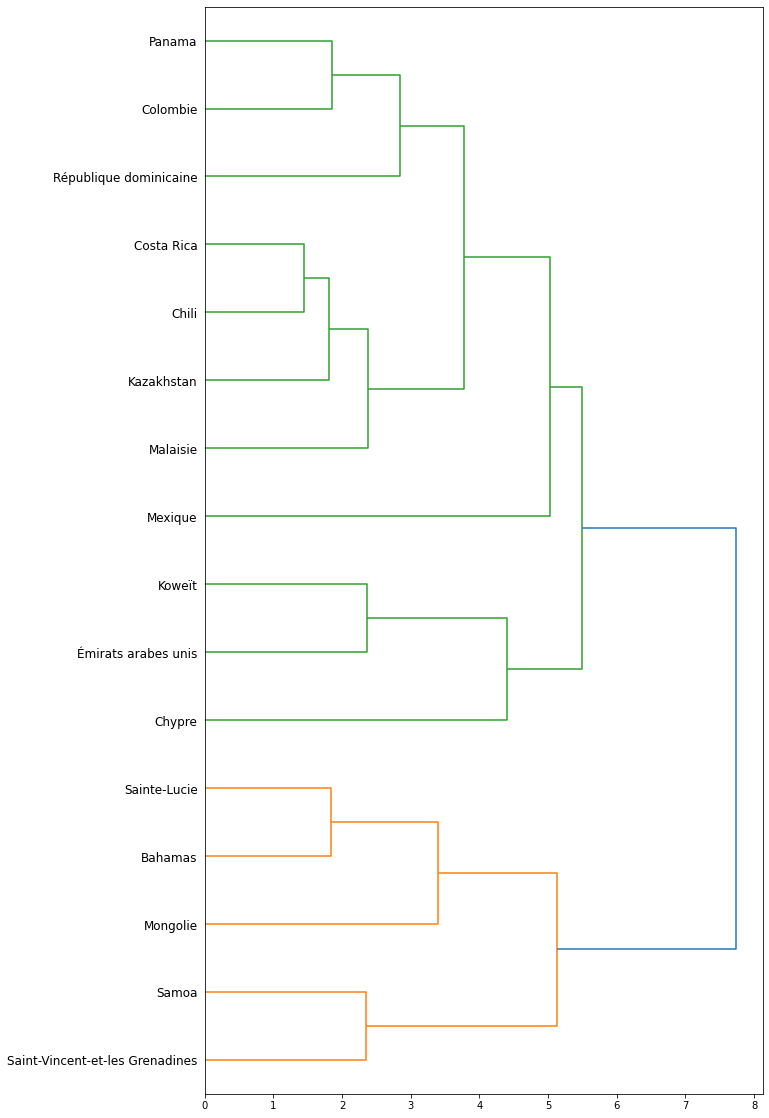

In [95]:
# Dendrogramme :
plt.figure(figsize=(10,20))
dendrogram(Z2, labels=pays2,orientation="right",color_threshold=6)
plt.show()

#### 3 - Clustering en K-Means :

In [96]:
# K-Means :
n_clust = 2
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled2)
clustersKM2 = km.labels_

In [97]:
# Préparation à la projection :
pca2 = decomposition.PCA().fit(X_scaled2)
Z_projected2 = pca2.transform(X_scaled2)

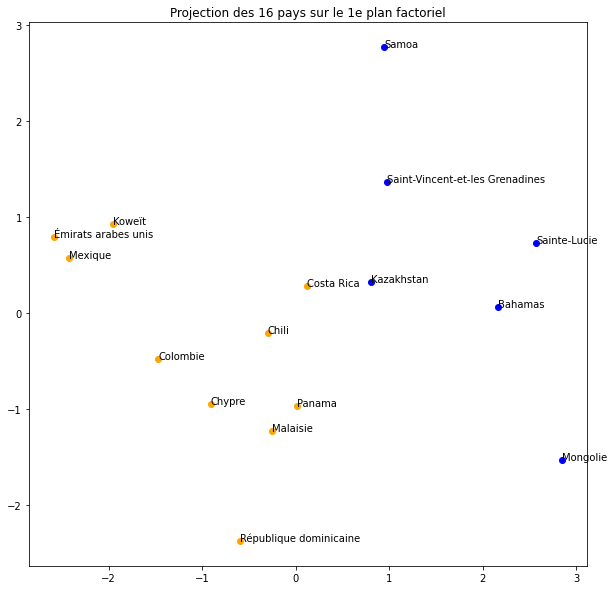

In [98]:
# Projection :
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange'],[0,1]):
    plt.scatter(Z_projected2[clustersKM2==k,0] , Z_projected2[clustersKM2==k,1],c=couleur)
for i,label in enumerate(dataChoix.index):
    plt.annotate(label,(Z_projected2[i,0],Z_projected2[i,1]))
plt.title("Projection des {} pays sur le 1e plan factoriel".format(Z_projected2.shape[0]))
plt.show()

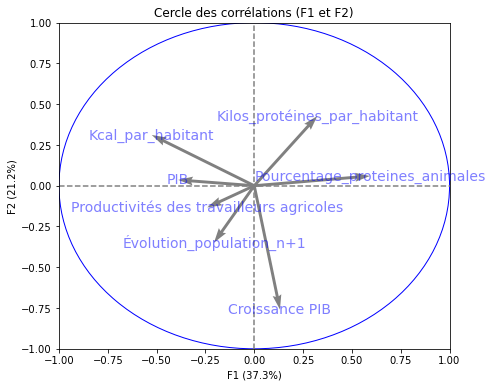

In [99]:
# Cercle des corrélations :
pcs2 = pca2.components_
labelsVariables2 = dataChoix.columns
display_circles(pcs2, 2, pca2,[(0,1)],labels = np.array(labelsVariables2))

#### 4 - Définition du groupe de pays choisis :

In [100]:
# Attribution des numéros de cluster :
dataChoixListe = pd.DataFrame({"Zone": pays2, "cluster":clustersKM2})

# Jointure avec le dataframe principal :
dataChoixListe = pd.merge(dataChoix, dataChoixListe, on="Zone")

# Groupement par cluster
dataChoixListe1 = dataChoixListe.loc[dataChoixListe["cluster"]==0]
dataChoixListe2 = dataChoixListe.loc[dataChoixListe["cluster"]==1]

In [101]:
# Présentation de la liste des pays choisis :
ListeÉlue = dataChoix.loc[["Chili","Chypre","Colombie","Costa Rica","Émirats arabes unis","Koweït","Malaisie","Mexique","Panama","République dominicaine"]]
ListeÉlue

,Évolution_population_n+1,Pourcentage_proteines_animales,Kilos_protéines_par_habitant,Kcal_par_habitant,PIB,Croissance PIB,Productivités des travailleurs agricoles
Zone,,,,,,,
Chili,1.402274,54.124836,18.104000,1105220.0,2.982580e+11,3.949321,11857.770508
Chypre,0.762712,49.743645,16.643999,1100475.0,2.530982e+10,5.240748,36525.843750
Colombie,1.535473,51.165661,13.618150,1135880.0,3.335689e+11,2.515324,6086.358887
Costa Rica,0.989899,55.775299,16.779051,1104855.0,6.055390e+10,2.660375,10388.328125
Émirats arabes unis,1.517867,45.764557,18.417900,1208880.0,4.222151e+11,1.189856,28233.027344
Koweït,1.997041,49.384750,18.604050,1266915.0,1.406454e+11,1.246274,12957.555664
Malaisie,1.359910,55.752098,15.760700,1037695.0,3.587151e+11,4.769927,18870.396484
Mexique,1.133222,48.939892,16.344700,1152305.0,1.222349e+12,2.194992,5927.986328
Panama,1.704407,53.172432,15.600100,1039885.0,6.512820e+10,3.692101,4326.692871


#### 5 - Conclusion :

Les dix pays choisis ont pour caractéristiques :
- Des ressources alimentaires encore très éloignées de celles des pays les plus riches.
- L'habitude de consommer régulièrement des protéines animales.
- Une croissance démographique assez soutenue.
- Une croissance économique.
- Tous ont accès à la mer.
- Dans le cadre d'une d'installation future possible, ils présentent une bonne productivité des travailleurs agricoles, et la plupart font partie d'un marché commun important (Union Européenne, Mercosur, Alena...).

Au sein de ces 10 pays, 2 semblent constituer d'excellents choix :
- Chypre : du fait qu'elle fait partie du marché commun européen. Le principe de la libre circulation des biens et des services au sein des États membres de l'UE permettrait d'y exporter des produits facilement, rapidement, et sereinement, que dans les autres destinations d'exportation potentielles. Rappelons que l'UE est troisième derrière la Chine et les USA dans la consommation de viande de volaille.
- Mexique : du fait de sa population (126 millions d'habitants), de sa richesse (12e nation en terme de PIB), de son goût pour le poulet (6e plus gros consommateur de viande de volaille) et, dans une perspective d'installation, sa position géographique entre l'Amérique latine et les USA et ses accords commerciaux.